Continuation of the 'examine structure' notebook to just finish this off

In [1]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "6" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import graph_util as gu
import plot_util as pu

from scipy.interpolate import interp1d

from Week7_PFNutils import *

2021-07-20 16:37:17.846419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-20 16:37:28.460511: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-20 16:37:28.474866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-20 16:37:28.599988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-20 16:37:28.600048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-20 16:37:28.648042: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

In [2]:
model_path = '/fast_scratch/atlas_images/v01-45/' 
data_path = '/data/atlas/'

In [3]:
file2224 = np.load(model_path+'nn_delta2224_DR.npz')
model_nog = tf.keras.models.load_model(model_path+'w8_pfn_noglob_2.hdf5')

In [4]:
X_test2224 = file2224['arr_2']
eta_test2224 = file2224['arr_5']
delR_test2224 = file2224['arr_17']

In [5]:
min(delR_test2224), max(delR_test2224)

(0.00014939645188860595, 4.258205413818359)

In [6]:
DR_ranges = np.arange(0., 4.31, .5375)

DR_sel = [abs(delR_test2224) < DR_ranges[1]]
for i in range(1, len(DR_ranges)):
    selec_ = (abs(delR_test2224) >= DR_ranges[i-1]) & (abs(delR_test2224) < DR_ranges[i])
    DR_sel.append(selec_)
print(delR_test2224[abs(delR_test2224) < DR_ranges[-1]])

[0.01442179 0.05252073 0.08907302 ... 0.69990724 0.7429418  0.02531027]


In [7]:
DR_ranges

array([0.    , 0.5375, 1.075 , 1.6125, 2.15  , 2.6875, 3.225 , 3.7625,
       4.3   ])

In [8]:
DR_sel

[array([ True,  True,  True, ..., False, False,  True]),
 array([ True,  True,  True, ..., False, False,  True]),
 array([False, False, False, ...,  True,  True, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [9]:
delR_test2224, DR_sel[0] #okay so maybe that worked?

(array([0.01442179, 0.05252073, 0.08907302, ..., 0.69990724, 0.7429418 ,
        0.02531027]),
 array([ True,  True,  True, ..., False, False,  True]))

In [10]:
predics = []
for selection in DR_sel:
    preds = model_nog.predict(X_test2224[selection], batch_size=1000)
    predics.append(preds)

2021-07-20 16:38:47.560522: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1059040000 exceeds 10% of free system memory.
2021-07-20 16:38:48.829103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-20 16:38:48.851834: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2021-07-20 16:38:49.063125: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-07-20 16:38:50.837630: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-07-20 16:39:14.281531: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1059040000 exceeds 10% of free system memory.


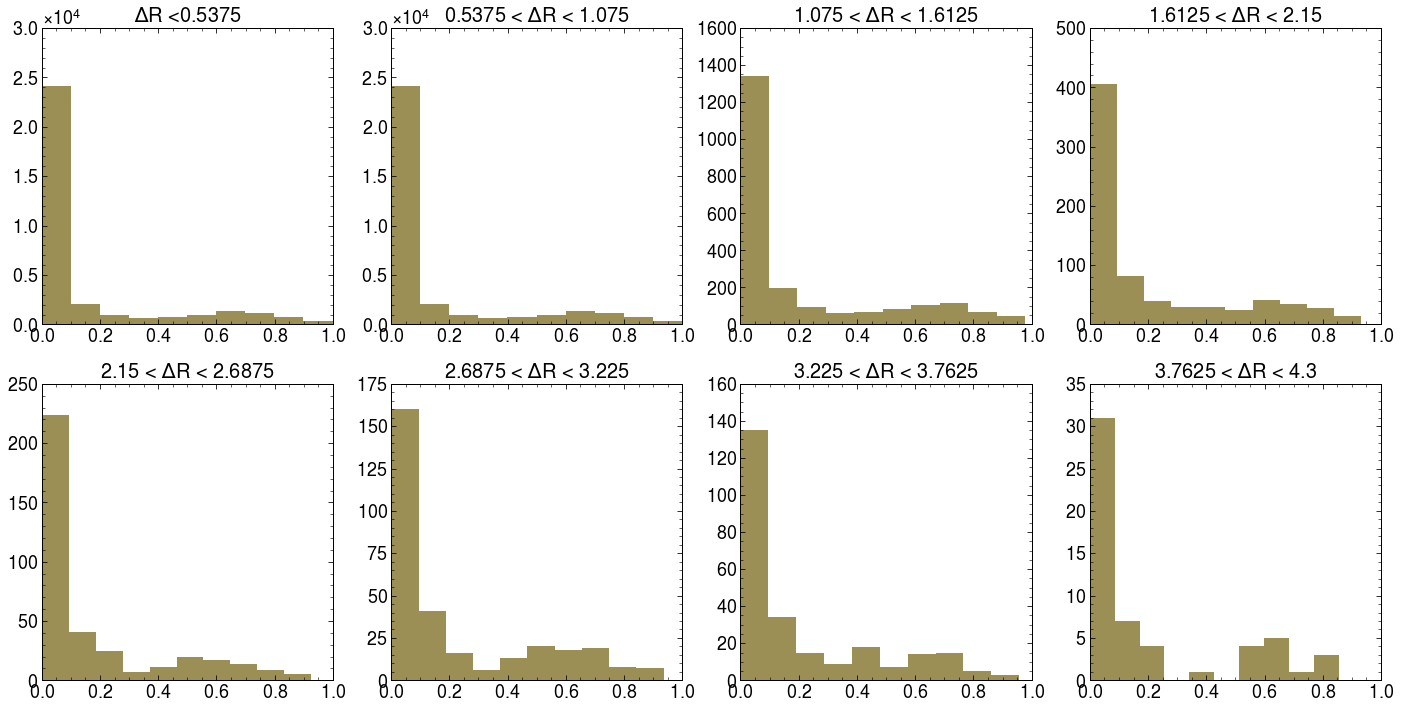

In [20]:
fig, ((ax1, ax2, ax3, ax7), (ax4, ax5, ax6, ax8)) = plt.subplots(2,4,figsize=[24,12])
axes = [ax1, ax2, ax3, ax7, ax4, ax5, ax6, ax8]
ranges = ['$\Delta R$ <' + str(DR_ranges[1]), str(DR_ranges[1])+ ' < $\Delta R$ < ' + str(DR_ranges[2]), str(DR_ranges[2]) + ' < $\Delta R$ < '+ str(np.round(DR_ranges[3], 4)), str(np.round(DR_ranges[3], 4))+' < $\Delta R$ < '+ str(DR_ranges[4]), str(DR_ranges[4])+' < $\Delta R$ < '+ str(DR_ranges[5]), str(DR_ranges[5])+' < $\Delta R$ < '+ str(np.round(DR_ranges[6], 4)), str(np.round(DR_ranges[6], 4))+' < $\Delta R$ < '+ str(np.round(DR_ranges[7],4)), str(np.round(DR_ranges[7], 4))+' < $\Delta R$ < '+ str(DR_ranges[8])]

for i in range(len(axes)):
    prob1, prob2 = predics[i].T
    axes[i].set_xlim(0,1)
    #axes[i].set_ylim(0,3e4)
    axes[i].set_title(ranges[i])
    axes[i].hist(prob1, color='xkcd:dark khaki')

In [22]:
#now I'm also gonna load up the stuff from the deltap delta0 notebook: note it starts with just delta+

filepnon = np.load(data_path+'nn_pnon_w12.npz')
filennop = np.load(data_path+'nn_nnop_w12.npz')
model_nog = tf.keras.models.load_model(model_path+'w8_pfn_noglob_2.hdf5')

In [23]:
X_testpnon = filepnon['arr_2']
eta_testpnon = filepnon['arr_5']
delR_testpnon = filepnon['arr_17']

X_testnnop = filennop['arr_2']
eta_testnnop = filennop['arr_5']
delR_testnnop = filennop['arr_17']

In [24]:
min(delR_testpnon), max(delR_testpnon)

(0.00024455119273625314, 4.8818206787109375)

In [25]:
min(delR_testnnop), max(delR_testnnop)

(0.0003158784529659897, 5.208575248718262)

In [38]:
DR_ranges_p = np.linspace(0., max(delR_testpnon)+.1, 9) #includes stop

DR_sel_p = [abs(delR_testpnon) < DR_ranges_p[1]]
for i in range(1, len(DR_ranges_p)):
    selec_ = (abs(delR_testpnon) >= DR_ranges_p[i-1]) & (abs(delR_testpnon) < DR_ranges_p[i])
    DR_sel_p.append(selec_)

In [39]:
DR_ranges_n = np.linspace(0., max(delR_testnnop)+.1, 9) #includes stop

DR_sel_n = [abs(delR_testnnop) < DR_ranges_n[1]]
for i in range(1, len(DR_ranges_n)):
    selec_ = (abs(delR_testnnop) >= DR_ranges_n[i-1]) & (abs(delR_testnnop) < DR_ranges_n[i])
    DR_sel_n.append(selec_)

In [40]:
DR_ranges_n

array([0.        , 0.66357191, 1.32714381, 1.99071572, 2.65428762,
       3.31785953, 3.98143144, 4.64500334, 5.30857525])

In [41]:
predics_n = []
for selection in DR_sel_n:
    preds = model_nog.predict(X_testnnop[selection], batch_size=1000)
    predics_n.append(preds)

In [42]:
predics_p = []
for selection in DR_sel_p:
    preds = model_nog.predict(X_testpnon[selection], batch_size=1000)
    predics_p.append(preds)

2021-07-21 12:30:31.418620: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 684384000 exceeds 10% of free system memory.


In [70]:
def plots(DR_ranges, predics, col):
    fig, ((ax1, ax2, ax3, ax7), (ax4, ax5, ax6, ax8)) = plt.subplots(2,4,figsize=[24,12])
    axes = [ax1, ax2, ax3, ax7, ax4, ax5, ax6, ax8]
    ranges = ['$\Delta R$ <' + str(np.round(DR_ranges[1], 4)), str(np.round(DR_ranges[1], 4))+ ' < $\Delta R$ < ' + str(np.round(DR_ranges[2], 4)), str(np.round(DR_ranges[2], 4)) + ' < $\Delta R$ < '+ str(np.round(DR_ranges[3], 4)), str(np.round(DR_ranges[3], 4))+' < $\Delta R$ < '+ str(np.round(DR_ranges[4], 4)), str(np.round(DR_ranges[4], 4))+' < $\Delta R$ < '+ str(np.round(DR_ranges[5], 4)), str(np.round(DR_ranges[5], 4))+' < $\Delta R$ < '+ str(np.round(DR_ranges[6], 4)), str(np.round(DR_ranges[6], 4))+' < $\Delta R$ < '+ str(np.round(DR_ranges[7],4)), str(np.round(DR_ranges[7], 4))+' < $\Delta R$ < '+ str(np.round(DR_ranges[8], 4))]

    for i in range(len(axes)):
        prob1, prob2 = predics[i].T
        axes[i].set_xlim(0,1)
        #axes[i].set_ylim(0,3e4)
        axes[i].set_title(ranges[i])
        axes[i].hist(prob1, color=col) #used olive brown, light tan, brown yellow, dark yellow

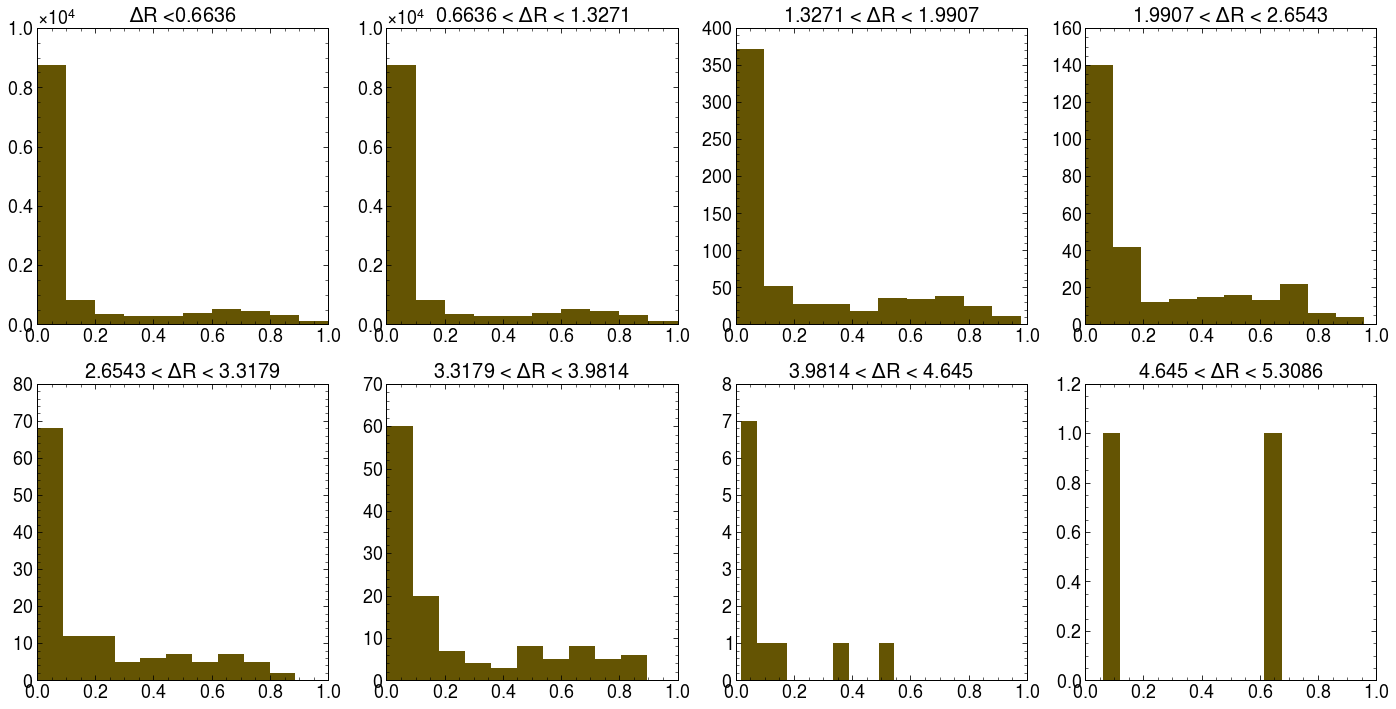

In [47]:
plots(DR_ranges_n, predics_n)

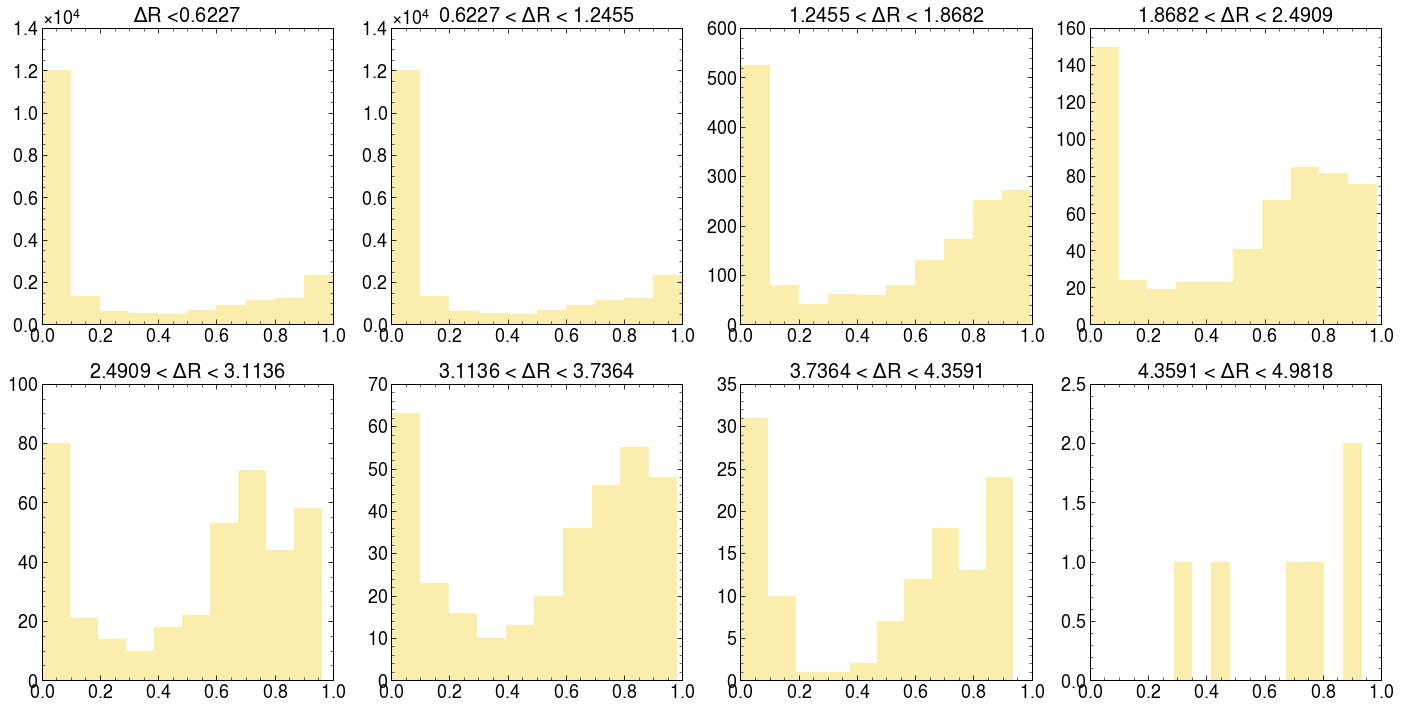

In [49]:
plots(DR_ranges_p, predics_p)

In [50]:
filed0pnon = np.load(data_path+'nn_del0pnon_w12.npz') #just so you know these are mislabeled now; pnon
                                                    #has pi0s and ns, and nnop has pi-s and ps
filed0nnop = np.load(data_path+'nn_del0nnop_w12.npz')

In [51]:
X_testd0pnon = filed0pnon['arr_2']
eta_testd0pnon = filed0pnon['arr_5']
delR_testd0pnon = filed0pnon['arr_17']

X_testd0nnop = filed0nnop['arr_2']
eta_testd0nnop = filed0nnop['arr_5']
delR_testd0nnop = filed0nnop['arr_17']

In [52]:
min(delR_testd0pnon), max(delR_testd0pnon)

(0.00029413963784463704, 5.090677261352539)

In [53]:
min(delR_testd0nnop), max(delR_testd0nnop)

(0.00032341634505428374, 4.92338228225708)

In [54]:
DR_ranges_pd0 = np.linspace(0., max(delR_testd0pnon)+.1, 9) #includes stop

DR_sel_pd0 = [abs(delR_testd0pnon) < DR_ranges_pd0[1]]
for i in range(1, len(DR_ranges_pd0)):
    selec_ = (abs(delR_testd0pnon) >= DR_ranges_pd0[i-1]) & (abs(delR_testd0pnon) < DR_ranges_pd0[i])
    DR_sel_pd0.append(selec_)

In [55]:
DR_ranges_nd0 = np.linspace(0., max(delR_testd0nnop)+.1, 9) #includes stop

DR_sel_nd0 = [abs(delR_testd0nnop) < DR_ranges_nd0[1]]
for i in range(1, len(DR_ranges_nd0)):
    selec_ = (abs(delR_testd0nnop) >= DR_ranges_nd0[i-1]) & (abs(delR_testd0nnop) < DR_ranges_nd0[i])
    DR_sel_nd0.append(selec_)

In [56]:
predics_nd0 = []
for selection in DR_sel_nd0:
    preds = model_nog.predict(X_testd0nnop[selection], batch_size=1000)
    predics_nd0.append(preds)

In [57]:
predics_pd0 = []
for selection in DR_sel_pd0:
    preds = model_nog.predict(X_testd0pnon[selection], batch_size=1000)
    predics_pd0.append(preds)

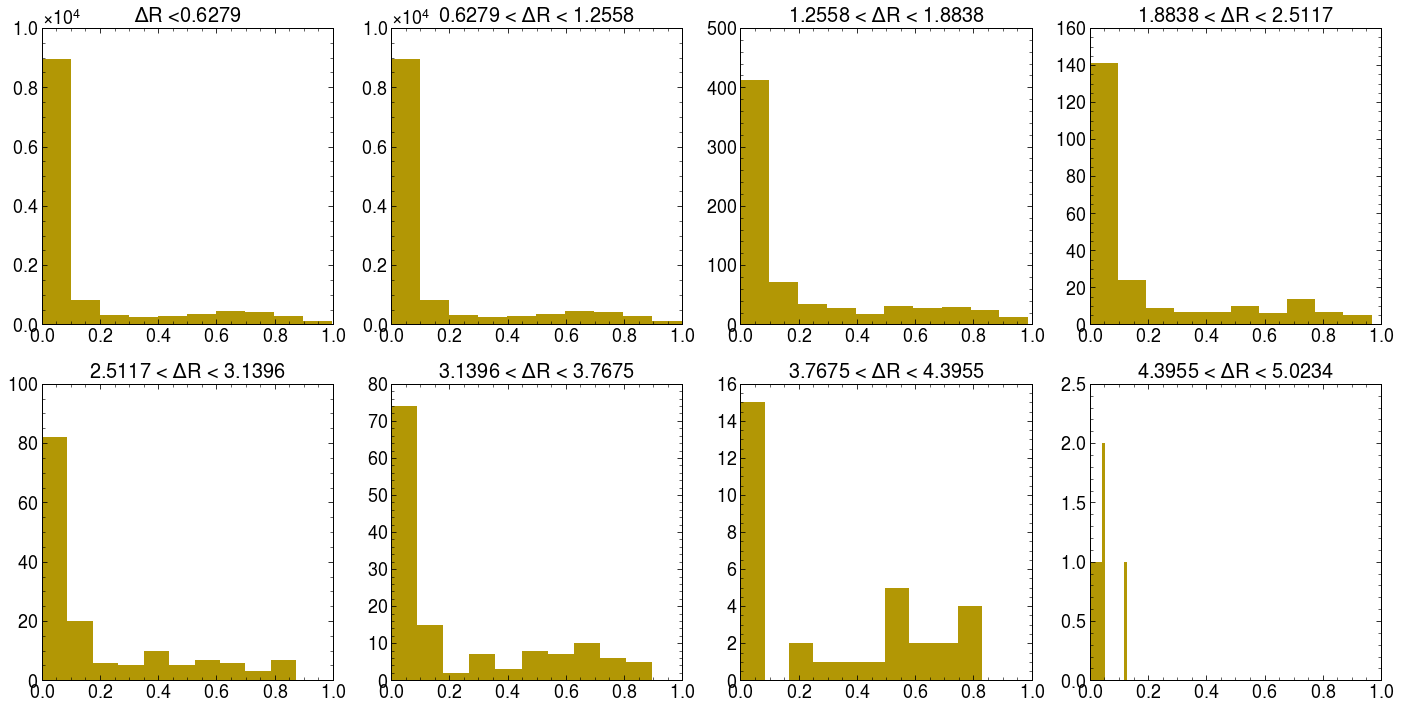

In [59]:
plots(DR_ranges_nd0, predics_nd0)

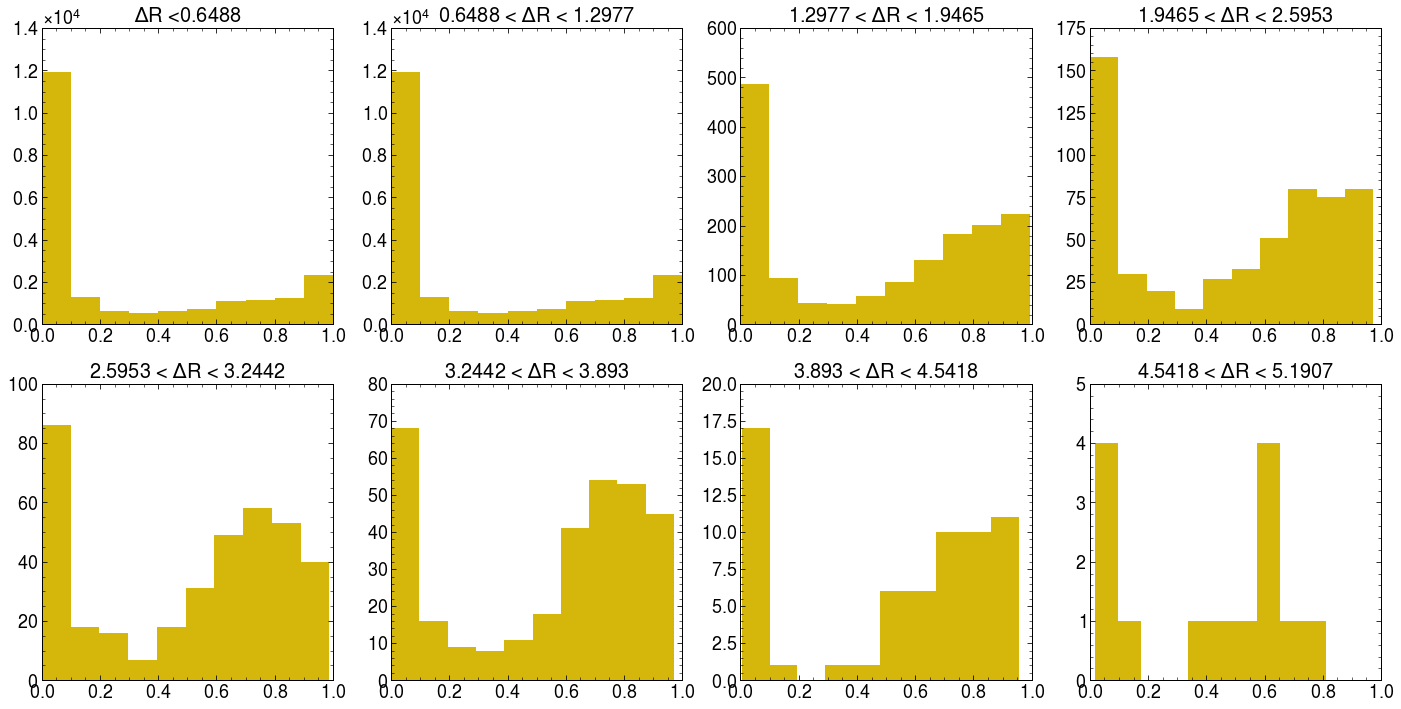

In [61]:
plots(DR_ranges_pd0, predics_pd0)

In [62]:
filead0pnon = np.load(data_path+'nn_antidel0pnon_w12.npz') #just so you know these are mislabeled now; pnon
                                                    #has pi0s and ns, and nnop has pi-s and ps
filead0nnop = np.load(data_path+'nn_antidel0nnop_w12.npz')

In [63]:
X_testad0pnon = filead0pnon['arr_2']
eta_testad0pnon = filead0pnon['arr_5']
delR_testad0pnon = filead0pnon['arr_17']

X_testad0nnop = filead0nnop['arr_2']
eta_testad0nnop = filead0nnop['arr_5']
delR_testad0nnop = filead0nnop['arr_17']

In [65]:
DR_ranges_pad0 = np.linspace(0., max(delR_testad0pnon)+.1, 9) #includes stop

DR_sel_pad0 = [abs(delR_testad0pnon) < DR_ranges_pad0[1]]
for i in range(1, len(DR_ranges_pad0)):
    selec_ = (abs(delR_testad0pnon) >= DR_ranges_pad0[i-1]) & (abs(delR_testad0pnon) < DR_ranges_pad0[i])
    DR_sel_pad0.append(selec_)

In [66]:
DR_ranges_nad0 = np.linspace(0., max(delR_testad0nnop)+.1, 9) #includes stop

DR_sel_nad0 = [abs(delR_testad0nnop) < DR_ranges_nad0[1]]
for i in range(1, len(DR_ranges_nad0)):
    selec_ = (abs(delR_testad0nnop) >= DR_ranges_nad0[i-1]) & (abs(delR_testad0nnop) < DR_ranges_nad0[i])
    DR_sel_nad0.append(selec_)

In [67]:
predics_nad0 = []
for selection in DR_sel_nad0:
    preds = model_nog.predict(X_testad0nnop[selection], batch_size=1000)
    predics_nad0.append(preds)
    
predics_pad0 = []
for selection in DR_sel_pad0:
    preds = model_nog.predict(X_testad0pnon[selection], batch_size=1000)
    predics_pad0.append(preds)

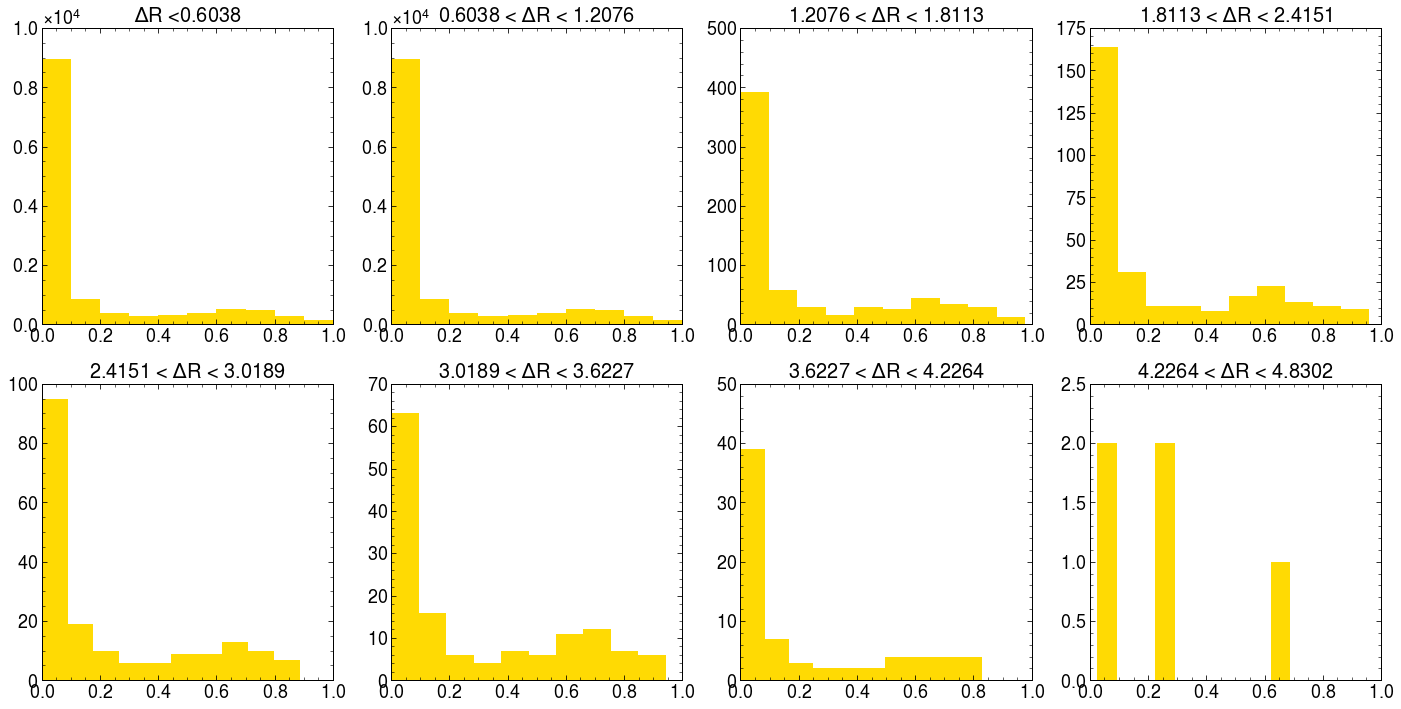

In [71]:
plots(DR_ranges_nad0, predics_nad0, col='xkcd:sunflower yellow') #anti-delta0, has anti-p and pi+, no anti-ns

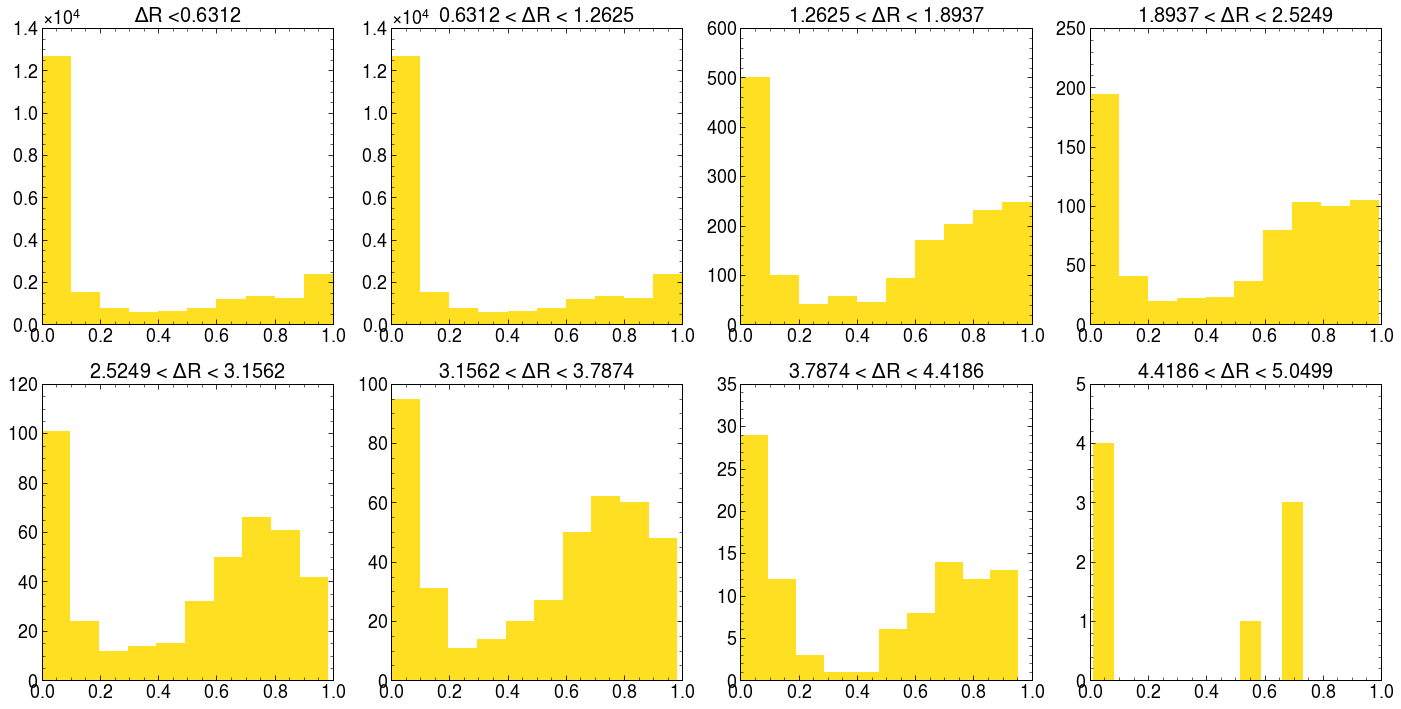

In [72]:
plots(DR_ranges_pad0, predics_pad0, col='xkcd:sun yellow') #anti-delta0, has anti-ns and pi0s, no anti-ps

In [73]:
fileadppnon = np.load(data_path+'nn_antidel+pnon_w12.npz') #just so you know these are mislabeled now; pnon
                                                    #has pi0s and ns, and nnop has pi-s and ps
fileadpnnop = np.load(data_path+'nn_antidel+nnop_w12.npz')

X_testadppnon = fileadppnon['arr_2']
eta_testadppnon = fileadppnon['arr_5']
delR_testadppnon = fileadppnon['arr_17']

X_testadpnnop = fileadpnnop['arr_2']
eta_testadpnnop = fileadpnnop['arr_5']
delR_testadpnnop = fileadpnnop['arr_17']

DR_ranges_padp = np.linspace(0., max(delR_testadppnon)+.1, 9) #includes stop

DR_sel_padp = [abs(delR_testadppnon) < DR_ranges_padp[1]]
for i in range(1, len(DR_ranges_padp)):
    selec_ = (abs(delR_testadppnon) >= DR_ranges_padp[i-1]) & (abs(delR_testadppnon) < DR_ranges_padp[i])
    DR_sel_padp.append(selec_)
    
DR_ranges_nadp = np.linspace(0., max(delR_testadpnnop)+.1, 9) #includes stop

DR_sel_nadp = [abs(delR_testadpnnop) < DR_ranges_nadp[1]]
for i in range(1, len(DR_ranges_nadp)):
    selec_ = (abs(delR_testadpnnop) >= DR_ranges_nadp[i-1]) & (abs(delR_testadpnnop) < DR_ranges_nadp[i])
    DR_sel_nadp.append(selec_)
    
predics_nadp = []
for selection in DR_sel_nadp:
    preds = model_nog.predict(X_testadpnnop[selection], batch_size=1000)
    predics_nadp.append(preds)
    
predics_padp = []
for selection in DR_sel_padp:
    preds = model_nog.predict(X_testadppnon[selection], batch_size=1000)
    predics_padp.append(preds)

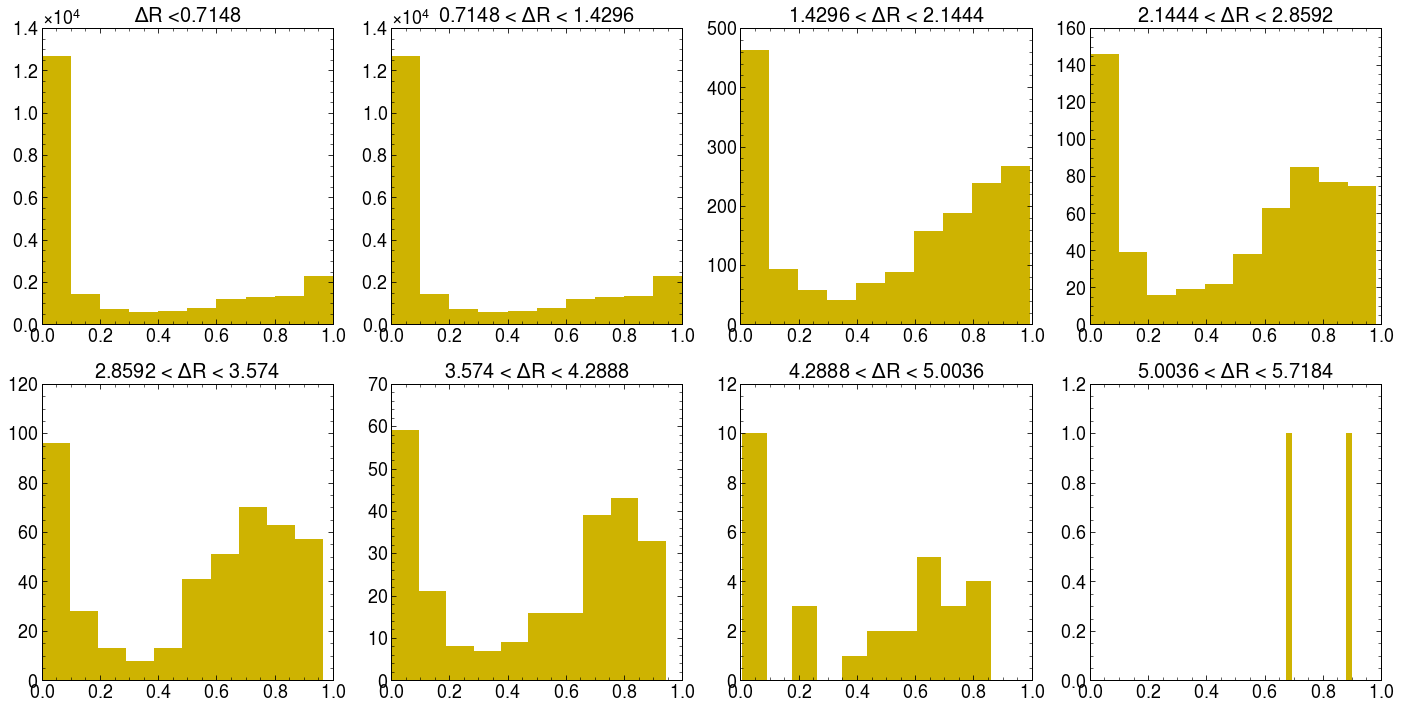

In [74]:
plots(DR_ranges_padp, predics_padp, col='xkcd:mustard') #anti-delta+, has anti-ps & pi0s, no anti-ns

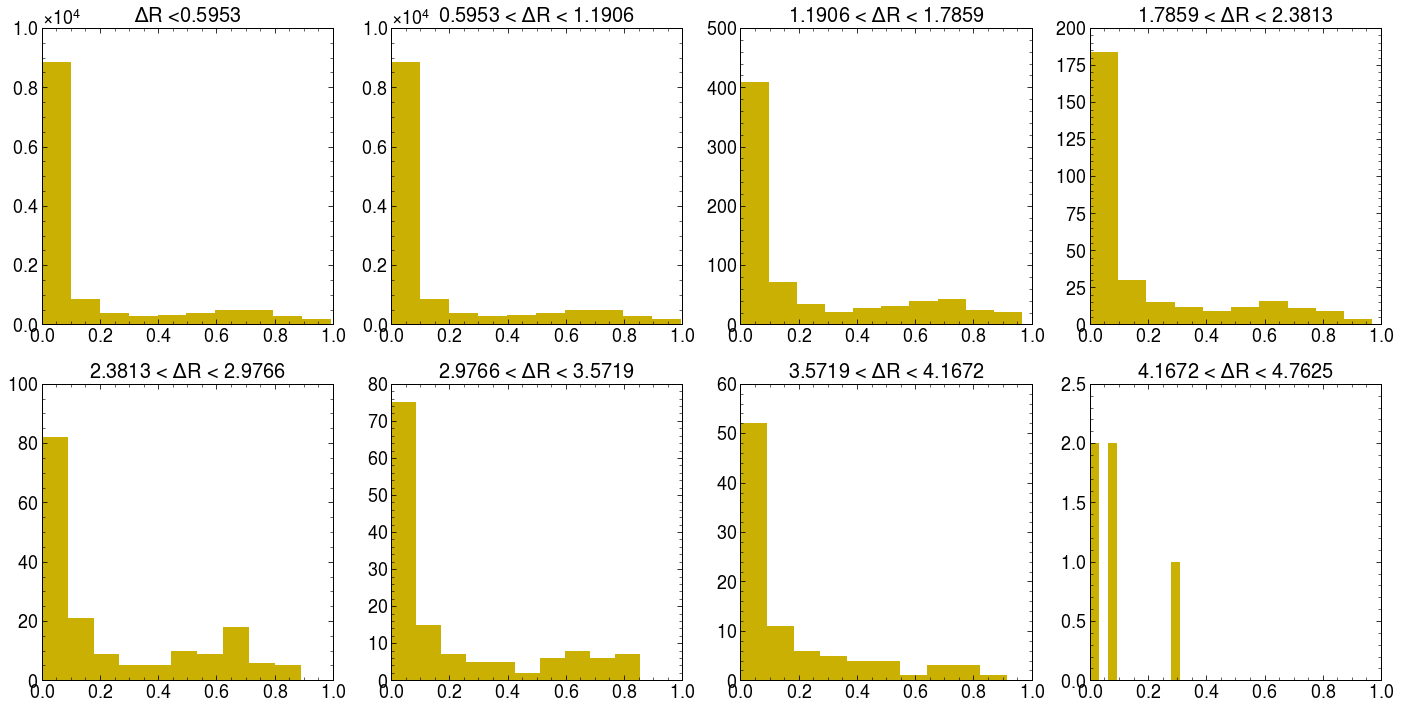

In [76]:
plots(DR_ranges_nadp, predics_nadp, col='xkcd:brownish yellow') #anti-delta+, has anti-n, pi-, no anti-ps

In [77]:
#I guess this notebook can stay as is but let's turn that into a nice function so I can put it in the utils

def deltaR_responseplots(file, model, col):
    X_test = file['arr_2']
    eta_test = file['arr_5']
    delR_test = file['arr_17']

    DR_ranges = np.linspace(0., max(delR_test)+.1, 9) #includes stop

    DR_sel = [abs(delR_test) < DR_ranges[1]]
    for i in range(1, len(DR_ranges)):
        selec_ = (abs(delR_test) >= DR_ranges[i-1]) & (abs(delR_test) < DR_ranges[i])
        DR_sel.append(selec_)

    predics = []
    for selection in DR_sel:
        preds = model_nog.predict(X_test[selection], batch_size=1000)
        predics.append(preds)
        
    plots(DR_ranges, predics, col=col)

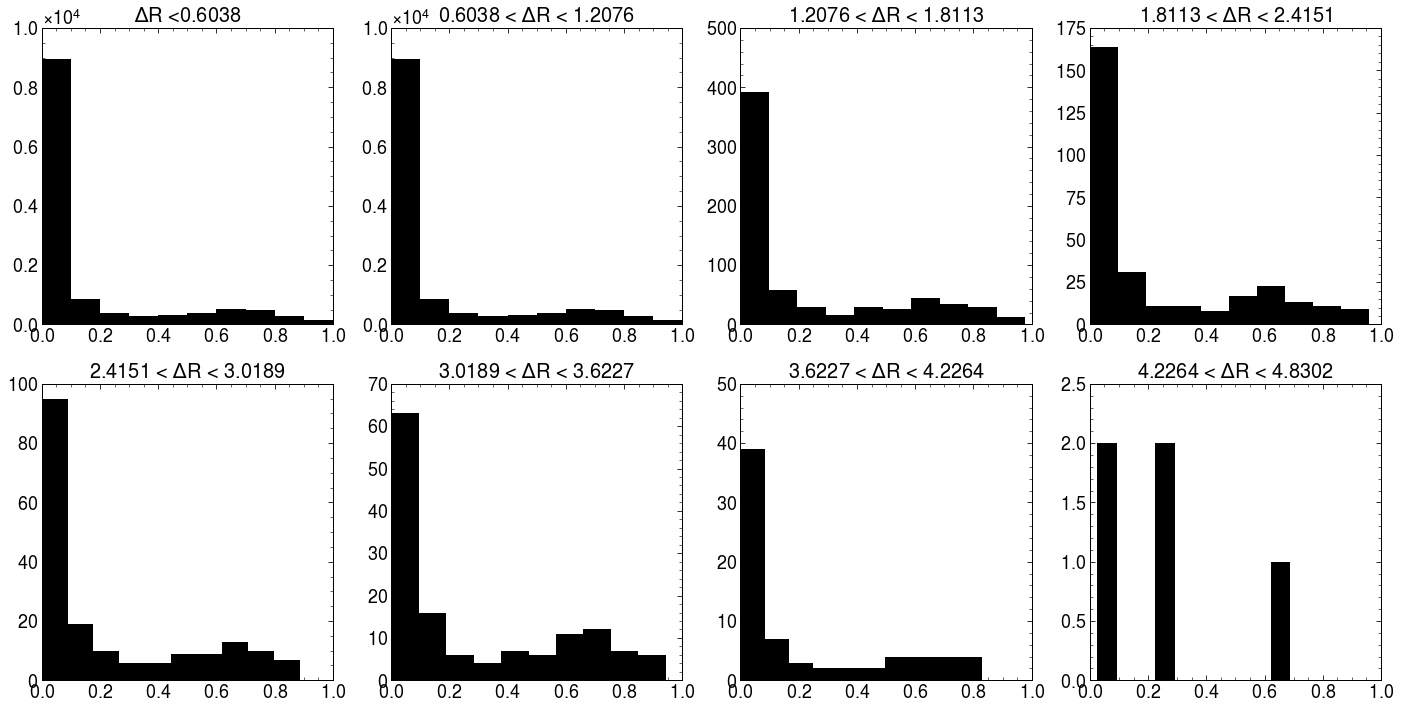

In [78]:
deltaR_responseplots(filead0nnop, model_nog, 'k') #okay cool so it works